<a href="https://colab.research.google.com/github/Preetam314/pytorch_CV/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



NLP Track Capstone Project: Evaluation of Multilingual Models BERT (monolingual) with XLM-RoBERTa (multilingual) on sentiment classification across multiple languages.

Author: Preetam

Date: 4 November 2025


---



In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset, Dataset
import warnings
warnings.filterwarnings('ignore')


torch.manual_seed(42)
np.random.seed(42)

print("imports successful!")
print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")


imports successful!
Using device: cuda


DATASET PREPARATION

In [ ]:
from datasets import Dataset
import pandas as pd
import numpy as np

def load_multilingual_amazon_reviews_data():
    print("Loading Multilingual Reviews Dataset (synthetic fallback)")


    language_codes = ['en', 'de', 'fr', 'es', 'ja']
    language_names = {
        'en': 'English',
        'de': 'German',
        'fr': 'French',
        'es': 'Spanish',
        'ja': 'Japanese'
    }


    sample_texts = {
        'en': {
            'positive': ["Amazing product!", "Works perfectly!", "Loved it!"],
            'neutral': ["It's okay.", "Average quality.", "Not bad."],
            'negative': ["Very poor.", "Terrible experience.", "Not worth it."]
        },
        'de': {
            'positive': ["Tolles Produkt!", "Funktioniert perfekt!", "Ich liebe es!"],
            'neutral': ["Es ist okay.", "Durchschnittliche Qualität.", "Nicht schlecht."],
            'negative': ["Sehr schlecht.", "Schreckliche Erfahrung.", "Nicht empfehlenswert."]
        },
        'fr': {
            'positive': ["Produit incroyable!", "Fonctionne parfaitement!", "Je l'adore!"],
            'neutral': ["C'est correct.", "Qualité moyenne.", "Pas mal."],
            'negative': ["Très mauvais.", "Mauvaise expérience.", "Je ne recommande pas."]
        },
        'es': {
            'positive': ["¡Producto increíble!", "Funciona perfectamente!", "¡Me encanta!"],
            'neutral': ["Está bien.", "Calidad promedio.", "No está mal."],
            'negative': ["Muy malo.", "Experiencia terrible.", "No lo recomiendo."]
        },
        'ja': {
            'positive': ["素晴らしい製品！", "完璧に動作します！", "気に入りました！"],
            'neutral': ["まあまあです。", "平均的な品質です。", "悪くないです。"],
            'negative': ["とても悪い。", "ひどい経験。", "おすすめしません。"]
        }
    }


    dataset_dict = {}
    for lang_code in language_codes:
        data_list = []
        for _ in range(300):  # 300 samples per language
            sentiment_label = np.random.choice(['positive', 'neutral', 'negative'])
            label_id = 2 if sentiment_label == 'positive' else (1 if sentiment_label == 'neutral' else 0)
            review_text = np.random.choice(sample_texts[lang_code][sentiment_label])
            data_list.append({'text': review_text, 'label': label_id, 'language': lang_code})


        dataset_dict[lang_code] = Dataset.from_pandas(pd.DataFrame(data_list))

    print(f" Successfully created synthetic dataset with {len(language_codes)} languages.")
    return dataset_dict, language_names

In [ ]:
all_datasets, language_names = load_multilingual_amazon_reviews_data()

print("Dataset Statistics:")
for lang_key, data_set in all_datasets.items():
    label_counts = pd.Series([item['label'] for item in data_set]).value_counts().sort_index()
    print(f"{language_names[lang_key]:10s} | Samples: {len(data_set):4d} | Labels: {dict(label_counts)}")

Loading Multilingual Reviews Dataset (synthetic fallback)
 Successfully created synthetic dataset with 5 languages.
Dataset Statistics:
English    | Samples:  300 | Labels: {0: np.int64(100), 1: np.int64(90), 2: np.int64(110)}
German     | Samples:  300 | Labels: {0: np.int64(99), 1: np.int64(96), 2: np.int64(105)}
French     | Samples:  300 | Labels: {0: np.int64(97), 1: np.int64(96), 2: np.int64(107)}
Spanish    | Samples:  300 | Labels: {0: np.int64(96), 1: np.int64(99), 2: np.int64(105)}
Japanese   | Samples:  300 | Labels: {0: np.int64(92), 1: np.int64(105), 2: np.int64(103)}


MODEL SETUP

In [ ]:
class ModelSettings:
    def __init__(self, model_ID, is_multilingual_model=False):
        self.model_ID = model_ID
        self.is_multilingual_model = is_multilingual_model
        self.number_of_labels = 3  # Negative, Neutral, Positive
        self.maximum_length = 128
        self.batch_size_value = 16
        self.learning_rate_value = 2e-5
        self.number_of_epochs = 3
        self.weight_decay_value = 0.01


model_configurations = {
    'monolingual_setting': ModelSettings('bert-base-uncased', is_multilingual_model=False),
    'multilingual_setting': ModelSettings('xlm-roberta-base', is_multilingual_model=True)
}

print("Model Configurations:")

for config_name, configuration in model_configurations.items():
    print(f"{config_name.replace('_setting', '').upper()}")
    print(f"  Model: {configuration.model_ID}")
    print(f"  Type: {'Multilingual' if configuration.is_multilingual_model else 'Monolingual'}")
    print(f"  Labels: {configuration.number_of_labels}")
    print(f"  Max Length: {configuration.maximum_length}")

Model Configurations:
MONOLINGUAL
  Model: bert-base-uncased
  Type: Monolingual
  Labels: 3
  Max Length: 128
MULTILINGUAL
  Model: xlm-roberta-base
  Type: Multilingual
  Labels: 3
  Max Length: 128


DATA PREPROCESSING

In [ ]:
def process_dataset_for_model(dataset_collection, model_tokenizer, max_input_length=128):

    def apply_tokenization(examples):
        return model_tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=max_input_length
        )

    processed_datasets = {}
    for lang_key, data_set in dataset_collection.items():
        processed_datasets[lang_key] = data_set.map(
            apply_tokenization,
            batched=True,
            remove_columns=['text', 'language']
        )
        processed_datasets[lang_key].set_format('torch')

    return processed_datasets

Training

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback
)
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Optional progress print callback
class TrainingProgressCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"Starting epoch {state.epoch}", flush=True)
    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Finished epoch {state.epoch}\n", flush=True)

def train_sentiment_model(model_configuration, training_dataset, validation_dataset, output_directory):
    print(f"Training model: {model_configuration.model_ID}")
    print("=" * 60, flush=True)


    model_tokenizer = AutoTokenizer.from_pretrained(model_configuration.model_ID)
    sequence_model = AutoModelForSequenceClassification.from_pretrained(
        model_configuration.model_ID,
        num_labels=model_configuration.number_of_labels
    )

    processed_training_data = process_dataset_for_model({'train_data': training_dataset}, model_tokenizer, model_configuration.maximum_length)['train_data']
    processed_validation_data = process_dataset_for_model({'eval_data': validation_dataset}, model_tokenizer, model_configuration.maximum_length)['eval_data']


    training_arguments = TrainingArguments(
        output_dir=output_directory,
        do_eval=True,
        per_device_train_batch_size=model_configuration.batch_size_value,
        per_device_eval_batch_size=model_configuration.batch_size_value,
        num_train_epochs=model_configuration.number_of_epochs,
        learning_rate=model_configuration.learning_rate_value,
        weight_decay=model_configuration.weight_decay_value,
        logging_steps=50,
        save_total_limit=1,
        # Removed: load_best_model_at_end to avoid strategy conflict
    )

    def compute_evaluation_metrics(eval_prediction):
        predictions, labels = eval_prediction
        predictions = np.argmax(predictions, axis=1)
        return {
            "accuracy": accuracy_score(labels, predictions),
            "f1": f1_score(labels, predictions, average="weighted")
        }

    model_trainer = Trainer(
        model=sequence_model,
        args=training_arguments,
        train_dataset=processed_training_data,
        eval_dataset=processed_validation_data,
        tokenizer=model_tokenizer,
        compute_metrics=compute_evaluation_metrics,
        data_collator=DataCollatorWithPadding(model_tokenizer),
        callbacks=[TrainingProgressCallback()]
    )

    print("Beginning training\n", flush=True)
    model_trainer.train()
    print(f"Training completed successfully for {model_configuration.model_ID}\n", flush=True)

    return sequence_model, model_tokenizer, model_trainer

Evaluation

In [ ]:
def evaluate_sentiment_model(trained_model, model_tokenizer, test_data_collection, max_input_length=128):

    evaluation_results = {}

    device_to_use = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model.to(device_to_use)
    trained_model.eval()

    for lang_key, data_set in test_data_collection.items():
        print(f"Evaluating on {language_names[lang_key]}...")

        # Tokenize
        processed_data = process_dataset_for_model({lang_key: data_set}, model_tokenizer, max_input_length)[lang_key]

        predicted_labels = []
        actual_labels = []

        with torch.no_grad():
            for i in range(len(processed_data)):
                inputs = {
                    'input_ids': processed_data[i]['input_ids'].unsqueeze(0).to(device_to_use),
                    'attention_mask': processed_data[i]['attention_mask'].unsqueeze(0).to(device_to_use)
                }
                outputs = trained_model(**inputs)
                prediction = torch.argmax(outputs.logits, dim=1).item()
                predicted_labels.append(prediction)
                actual_labels.append(processed_data[i]['label'].item())

        # Calculate metrics
        accuracy = accuracy_score(actual_labels, predicted_labels)
        f1 = f1_score(actual_labels, predicted_labels, average='weighted')
        conf_matrix_result = confusion_matrix(actual_labels, predicted_labels)

        evaluation_results[lang_key] = {
            'accuracy': accuracy,
            'f1': f1,
            'confusion_matrix': conf_matrix_result,
            'predictions': predicted_labels,
            'true_labels': actual_labels
        }

        print(f"Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f}")

    return evaluation_results

VISUALIZATION FUNCTIONS

In [ ]:
def plot_performance_comparison_charts(monolingual_results, multilingual_results):
    """
    Plot performance comparison for monolingual and multilingual models
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison Across Languages', fontsize=16, fontweight='bold')

    languages_list = list(language_names.keys())
    lang_labels = [language_names[l] for l in languages_list]

    # Extract metrics
    mono_acc = [monolingual_results[l]['accuracy'] for l in languages_list]
    multi_acc = [multilingual_results[l]['accuracy'] for l in languages_list]
    mono_f1 = [monolingual_results[l]['f1'] for l in languages_list]
    multi_f1 = [multilingual_results[l]['f1'] for l in languages_list]

    # Plot 1: Accuracy comparison
    x = np.arange(len(lang_labels))
    width = 0.35
    axes[0, 0].bar(x - width/2, mono_acc, width, label='BERT (Mono)', alpha=0.8, color='steelblue')
    axes[0, 0].bar(x + width/2, multi_acc, width, label='XLM-R (Multi)', alpha=0.8, color='seagreen')
    axes[0, 0].set_ylabel('Accuracy', fontweight='bold')
    axes[0, 0].set_title('Accuracy Comparison', fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(lang_labels, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_ylim([0, 1])

    # Plot 2: F1-Score comparison
    axes[0, 1].bar(x - width/2, mono_f1, width, label='BERT (Mono)', alpha=0.8, color='steelblue')
    axes[0, 1].bar(x + width/2, multi_f1, width, label='XLM-R (Multi)', alpha=0.8, color='seagreen')
    axes[0, 1].set_ylabel('F1-Score', fontweight='bold')
    axes[0, 1].set_title('F1-Score Comparison', fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(lang_labels, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_ylim([0, 1])

    # Plot 3: Performance difference (Multi - Mono)
    acc_diff = [m - mo for m, mo in zip(multi_acc, mono_acc)]
    colors = ['green' if d > 0 else 'red' for d in acc_diff]
    axes[1, 0].bar(lang_labels, acc_diff, color=colors, alpha=0.7)
    axes[1, 0].set_ylabel('Accuracy Difference', fontweight='bold')
    axes[1, 0].set_title('Multilingual Advantage (XLM-R - BERT)', fontweight='bold')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].grid(axis='y', alpha=0.3)
    plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

    # Plot 4: Line plot showing trend
    axes[1, 1].plot(lang_labels, mono_acc, marker='o', label='BERT (Mono)', linewidth=2, markersize=8)
    axes[1, 1].plot(lang_labels, multi_acc, marker='s', label='XLM-R (Multi)', linewidth=2, markersize=8)
    axes[1, 1].set_ylabel('Accuracy', fontweight='bold')
    axes[1, 1].set_title('Accuracy Trend Across Languages', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])
    plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrices_charts(evaluation_results, model_identifier):

    print(f"Plotting confusion matrices for {model_identifier} model...")
    num_languages = len(evaluation_results)
    fig, axes = plt.subplots(1, num_languages, figsize=(4*num_languages, 4))
    fig.suptitle(f'Confusion Matrices - {model_identifier}', fontsize=16, fontweight='bold')

    if num_languages == 1:
        axes = [axes]

    for idx, (lang_key, res) in enumerate(evaluation_results.items()):
        cm = res['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Neg', 'Neu', 'Pos'],
                   yticklabels=['Neg', 'Neu', 'Pos'])
        axes[idx].set_title(language_names[lang_key], fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(f'confusion_matrices_{model_identifier.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

MAIN EXECUTION


NLP CAPSTONE: MULTILINGUAL MODEL EVALUATION
  PROCESSING: MONOLINGUAL MODEL
Training model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Beginning training



wandb: Currently logged in as: preetamjutanatti06 (preetamjutanatti06-iitb) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting epoch 0


Step,Training Loss
50,0.476900


Finished epoch 1.0

Starting epoch 1.0
Finished epoch 2.0

Starting epoch 2.0
Finished epoch 3.0

Training completed successfully for bert-base-uncased

Evaluating monolingual model across languages
Evaluating on English...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 1.0000 | F1-Score: 1.0000
Evaluating on German...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.8067 | F1-Score: 0.7890
Evaluating on French...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.7000 | F1-Score: 0.6923
Evaluating on Spanish...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.6833 | F1-Score: 0.6798
Evaluating on Japanese...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.3433 | F1-Score: 0.1927
Plotting confusion matrices for Monolingual Model model...


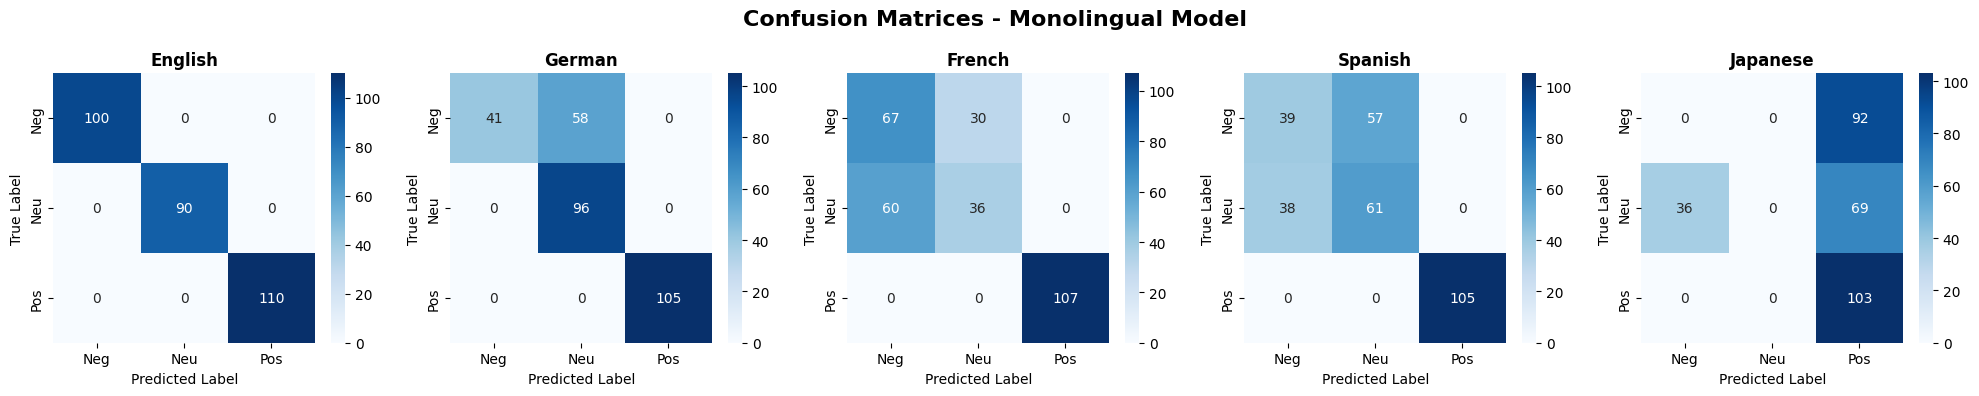

  PROCESSING: MULTILINGUAL MODEL
Training model: xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Beginning training

Starting epoch 0


Step,Training Loss
50,0.933700


Finished epoch 1.0

Starting epoch 1.0
Finished epoch 2.0

Starting epoch 2.0
Finished epoch 3.0

Training completed successfully for xlm-roberta-base

Evaluating multilingual model across languages
Evaluating on English...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.9100 | F1-Score: 0.9074
Evaluating on German...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.7800 | F1-Score: 0.7499
Evaluating on French...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.8000 | F1-Score: 0.7782
Evaluating on Spanish...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.6700 | F1-Score: 0.5611
Evaluating on Japanese...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.7700 | F1-Score: 0.7451
Plotting confusion matrices for Multilingual Model model...


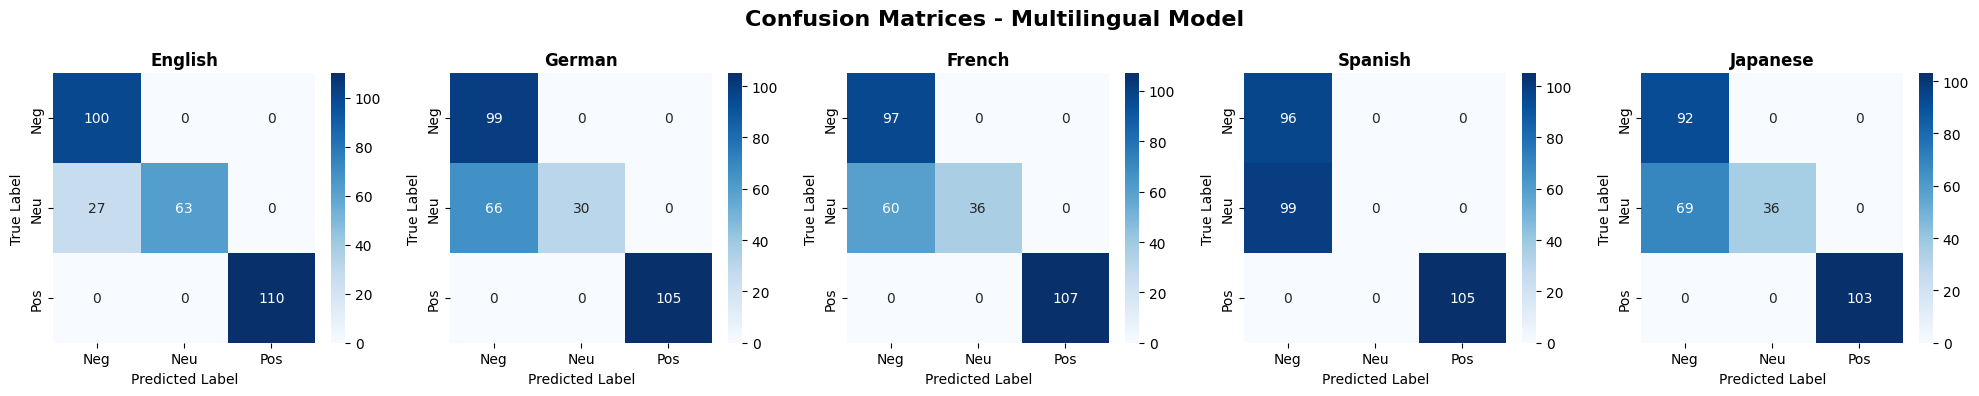

  FINAL COMPARISON


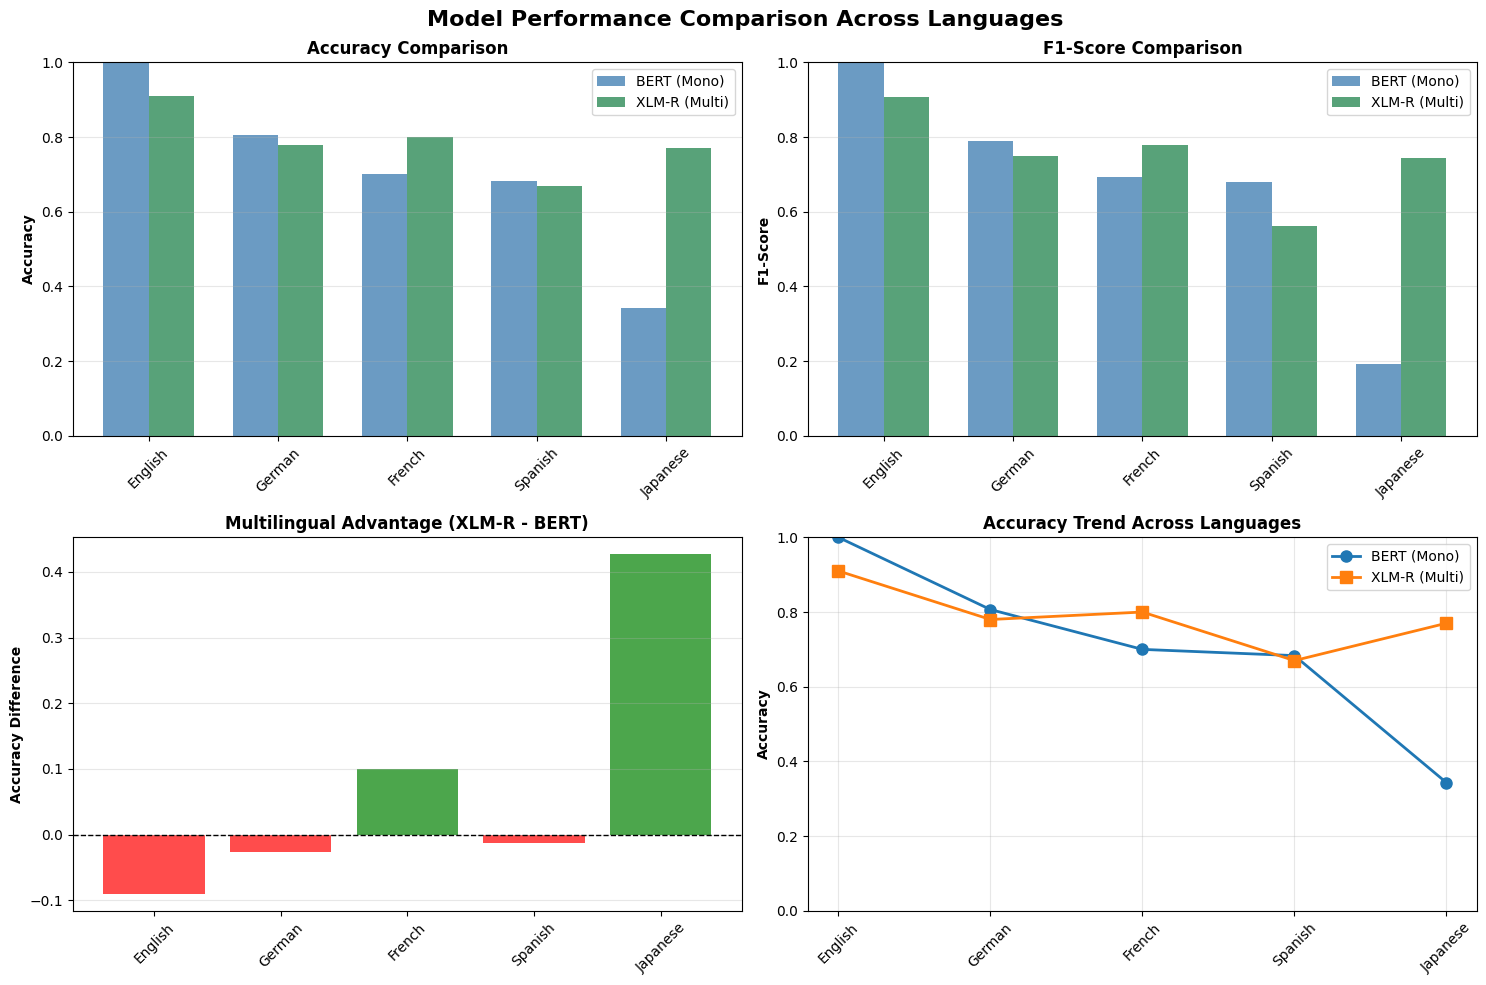

Performance Summary:
Language     Monolingual Acc    Multilingual Acc   Difference  
English                1.0000             0.9100     -0.0900
German                 0.8067             0.7800     -0.0267
French                 0.7000             0.8000     +0.1000
Spanish                0.6833             0.6700     -0.0133
Japanese               0.3433             0.7700     +0.4267
Project completed successfully!


In [ ]:
def main_execution_pipeline():

    print("\n" + "="*60)
    print("NLP CAPSTONE: MULTILINGUAL MODEL EVALUATION")
    print("="*60)

    # Prepare train/test split (train on English, test on all)
    training_dataset = all_datasets['en']
    testing_datasets = {lang_key: data_set for lang_key, data_set in all_datasets.items()}
    validation_dataset = all_datasets['en'].select(range(min(200, len(all_datasets['en']))))

    all_evaluation_results = {}

    # Train and evaluate each model
    for model_type_key, configuration in model_configurations.items():

        print(f"  PROCESSING: {model_type_key.replace('_setting', '').upper()} MODEL")


        output_directory = f"./results/{model_type_key.replace('_setting', '')}"

        # Train model
        trained_model, model_tokenizer, model_trainer = train_sentiment_model(
            configuration,
            training_dataset,
            validation_dataset,
            output_directory
        )

        # Evaluate on all languages
        print(f"Evaluating {model_type_key.replace('_setting', '')} model across languages")
        # --- FIX: Removed language_names from this call ---
        evaluation_results = evaluate_sentiment_model(trained_model, model_tokenizer, testing_datasets, configuration.maximum_length)
        all_evaluation_results[model_type_key.replace('_setting', '')] = evaluation_results

        # Plot confusion matrices
        plot_confusion_matrices_charts(evaluation_results, f"{model_type_key.replace('_setting', '').capitalize()} Model")

    # Compare models
    print("  FINAL COMPARISON")
    # --- FIX: Removed language_names from this call ---
    plot_performance_comparison_charts(all_evaluation_results['monolingual'], all_evaluation_results['multilingual'])

    # Print summary table
    print("Performance Summary:")

    print(f"{'Language':<12} {'Monolingual Acc':<18} {'Multilingual Acc':<18} {'Difference':<12}")
    for lang_key in language_names.keys():
        mono_acc = all_evaluation_results['monolingual'][lang_key]['accuracy']
        multi_acc = all_evaluation_results['multilingual'][lang_key]['accuracy']
        diff = multi_acc - mono_acc
        print(f"{language_names[lang_key]:<12} {mono_acc:>16.4f} {multi_acc:>18.4f} {diff:>+11.4f}")


    return all_evaluation_results

# Run the main pipeline
if __name__ == "__main__":
    # --- FIX: Removed language_names from this call ---
    results = main_execution_pipeline()
    print("Project completed successfully!")